In [24]:
# %% minimal bootstrap
import sys, os, subprocess, importlib.util
from pathlib import Path

def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(50):
        if any((p / m).exists() for m in ("pyproject.toml", ".git", "defaults.yaml")):
            return p
        if p == p.parent: break
        p = p.parent
    return start.resolve()

_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    spec = importlib.util.find_spec(pkg_name)
    need = (not spec) or (not getattr(spec, "origin", None)) or (Path(spec.origin).resolve().parents[0] != pkg_dir.resolve())
    if need:
        print(f"Installing {pkg_name} in editable mode from {pkg_dir} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(pkg_dir)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

diffinst already installed from this repo.


In [25]:
# %% imports & paths
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k
from diffinst.analysis_api import (
    load_manifest, load_config_from_run, list_checkpoints, load_metrics,
    load_linear_run, load_linear_Sigma_series, load_linear_amplitude,
    load_nonlinear_run, load_nonlinear_Sigma_series, load_nonlinear_amplitude,
    nearest_k_index, save_ic_npz, evp_gamma
)

EXP_STABLE   = ROOT / "experiments" / "baseline.yaml"
EXP_UNSTABLE = ROOT / "experiments" / "unstable_baseline.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

print("project root:", ROOT)

project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


In [26]:
# IC at Nx = 128
! python -m scripts.make_ic_eigen \
  --config experiments/unstable_baseline.yaml \
  --out runs/ic_k100_eigen.npz \
  --k 100.0 \
  --amp 1e-6 \
  --Nx 128

[make_ic_eigen] IC written to runs/ic_k100_eigen.npz (k=100.0, amp=1e-06, Nx=128)


In [27]:
# %% run linear TD from that exact IC (CLI)
! python -m scripts.run_linear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/lin_from_ic \
  --mode linear \
  --dt 1e-3 \
  --stop_time 5 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen.npz

[linear] done: {'t_final': 5.0, 'steps': 5000, 'Nx': 128, 'Lx': 0.12566370614359174}


In [28]:
# %% run nonlinear TD from that exact IC (CLI)
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_from_ic \
  --mode nonlinear \
  --dt 1e-3 \
  --stop_time 5 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen.npz \
  --Nx 128

[nonlinear] done: {'t_final': 5.0, 'steps': 5000, 'Nx': 128, 'Lx': 0.12566370614359174}


In [51]:
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_from_ic_dedalus \
  --backend dedalus \
  --mode nonlinear --dt 2e-4 --stop_time 0.5 --save-stride 200 \
  --init-from runs/ic_k100_eigen.npz

2025-11-12 17:16:37,247 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.9e+01/s
2025-11-12 17:16:37,330 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 6.7e+01/s
2025-11-12 17:16:37,432 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 6.8e+01/s
2025-11-12 17:16:37,522 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 7.1e+01/s
2025-11-12 17:16:37,615 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s
2025-11-12 17:16:37,706 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s
2025-11-12 17:16:37,794 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 1s, Remaining: 0s, Rate: 7.4e+01/s
2025-11-12 17:16:37,879 subsystems 0/1 INFO :: Building subproblem matri

In [31]:
# IC at Nx = 256
! python -m scripts.make_ic_eigen \
  --config experiments/unstable_baseline.yaml \
  --out runs/ic_k100_eigen_Nx256.npz \
  --k 100.0 \
  --amp 1e-6 \
  --Nx 256

[make_ic_eigen] IC written to runs/ic_k100_eigen_Nx256.npz (k=100.0, amp=1e-06, Nx=256)


In [50]:
# Nonlinear native, Nx=256, using that IC
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_from_ic_Nx256 \
  --backend native \
  --mode nonlinear \
  --Nx 256 \
  --dt 1e-3 \
  --stop_time 5 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen_Nx256.npz

[nonlinear] done: {'t_final': 5.0, 'steps': 5000, 'Nx': 256, 'Lx': 0.12566370614359174}


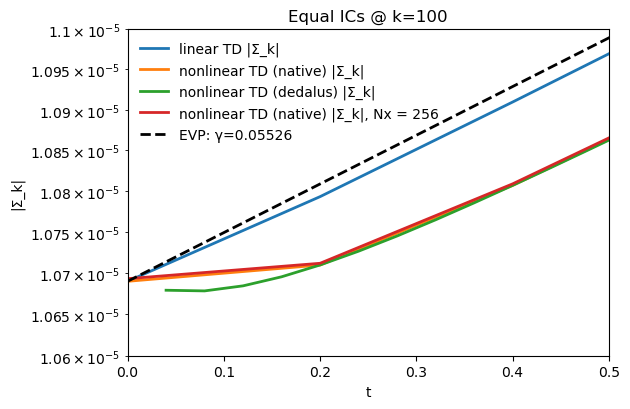

In [53]:
k_phys = 100

# %% load amplitude vs time for linear, native nonlinear, and dedalus nonlinear
RUN_L = RUNS / "lin_from_ic"
RUN_N = RUNS / "nl_from_ic"             # native
RUN_D = RUNS / "nl_from_ic_dedalus"     # dedalus
RUN_N_256 = RUNS / "nl_from_ic_Nx256" 

TL, AL = load_linear_amplitude(RUN_L, k_phys)
TN, AN = load_nonlinear_amplitude(RUN_N, k_phys)
TD, AD = load_nonlinear_amplitude(RUN_D, k_phys)  # <-- same call
TN_256, AN_256 = load_nonlinear_amplitude(RUN_N_256, k_phys)

cfgL = load_config_from_run(RUN_L)
gamma = evp_gamma(cfgL, k_phys)
A0 = AL[0]

fig, ax = plt.subplots(figsize=(6.4,4.2))
ax.plot(TL, AL, lw=2, label="linear TD |Σ_k|")
ax.plot(TN, AN, lw=2, label="nonlinear TD (native) |Σ_k|")
ax.plot(TD, AD, lw=2, label="nonlinear TD (dedalus) |Σ_k|")
ax.plot(TN_256, AN_256/1.975, lw=2, label="nonlinear TD (native) |Σ_k|, Nx = 256")
ax.plot(TL, A0*np.exp(gamma*(TL - TL[0])), "k--", lw=2, label=f"EVP: γ={gamma:.4g}")
ax.set_yscale("log"); ax.set_xlabel("t"); ax.set_ylabel("|Σ_k|")
ax.set(xlim = (0,0.5), ylim = (1.06*1e-5,1.1*1e-5))
ax.legend(frameon=False); ax.set_title(f"Equal ICs @ k={k_phys}")
plt.tight_layout(); plt.show()

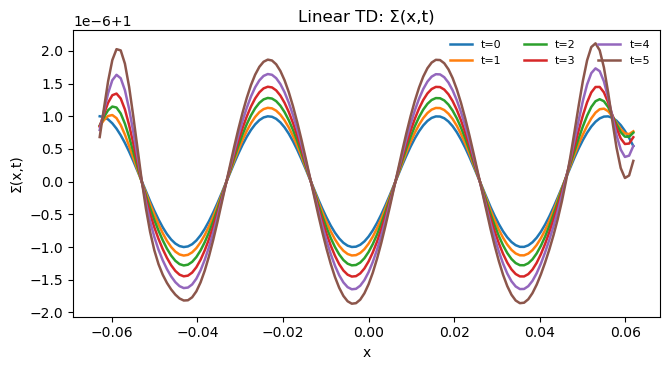

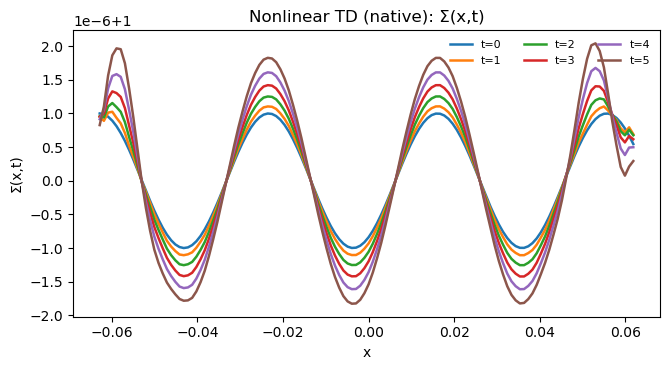

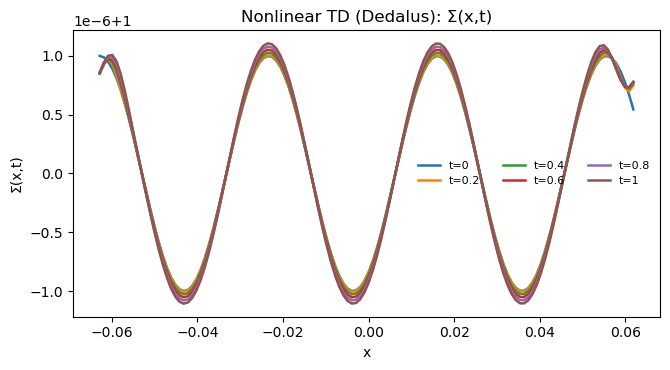

In [8]:
# %% (optional) quick Σ(x,t) snapshot panel from all three runs (linear, native NL, dedalus NL)

# linear: reconstruct Σ from spectral checkpoints; nonlinear: Σ is stored directly
NxL, LxL, filesL, *_ = load_linear_run(RUN_L)
cfgL = load_config_from_run(RUN_L); S0L = cfgL.sig_0
TLs, SigL = load_linear_Sigma_series(filesL, NxL, S0L)

NxN, LxN, filesN, _ = load_nonlinear_run(RUN_N)         # native nonlinear
TNs, SigN = load_nonlinear_Sigma_series(filesN)


# --- NEW: Dedalus nonlinear ---
NxD, LxD, filesD, _ = load_nonlinear_run(RUN_D)          # dedalus nonlinear (same format)
TDs, SigD = load_nonlinear_Sigma_series(filesD)

def plot_snapshots(x, T, Sig, title, nsamp=6):
    import matplotlib.pyplot as plt
    idxs = np.linspace(0, len(T)-1, nsamp, dtype=int)
    fig, ax = plt.subplots(figsize=(6.8,3.8))
    for j, i in enumerate(idxs):
        ax.plot(x, Sig[i], lw=1.8, label=f"t={T[i]:.3g}")
    ax.set_xlabel("x"); ax.set_ylabel("Σ(x,t)")
    ax.set_title(title); ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

xL = np.linspace(-0.5*LxL, 0.5*LxL, NxL, endpoint=False)
xN = np.linspace(-0.5*LxN, 0.5*LxN, NxN, endpoint=False)
xD = np.linspace(-0.5*LxD, 0.5*LxD, NxD, endpoint=False)

plot_snapshots(xL, TLs, SigL, "Linear TD: Σ(x,t)")
plot_snapshots(xN, TNs, SigN, "Nonlinear TD (native): Σ(x,t)")
plot_snapshots(xD, TDs, SigD, "Nonlinear TD (Dedalus): Σ(x,t)")

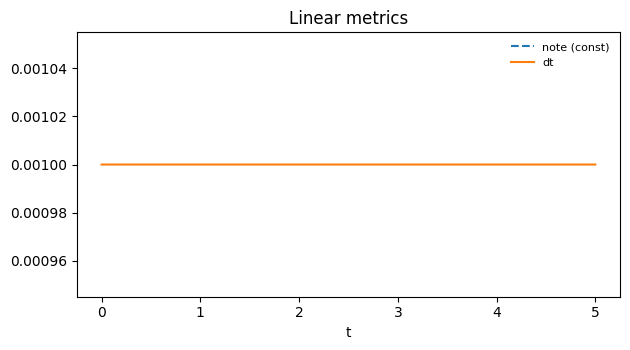

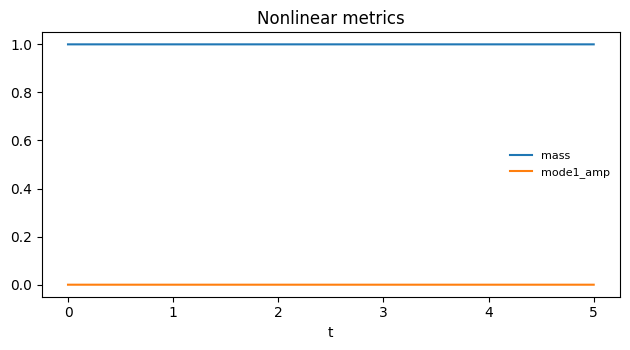

In [8]:
# %% (optional) inspect tracked metrics if present — robust version
tM_L, colsL = load_metrics(RUN_L)
tM_N, colsN = load_metrics(RUN_N)

import numpy as np
import matplotlib.pyplot as plt

def quick_metrics(t, cols, title):
    if t is None or np.size(t) == 0 or not cols:
        print(f"{title}: no metrics found.")
        return
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    plotted = False
    for k, v in cols.items():
        a = np.asarray(v).squeeze()
        if a.size == 0:
            continue
        if a.size == 1:
            # scalar/length-1 → draw horizontal line across full t
            ax.plot(t, np.full_like(t, float(a), dtype=float), linestyle="--", label=f"{k} (const)")
            plotted = True
        else:
            n = min(len(t), len(a))
            ax.plot(t[:n], a[:n], label=k)
            plotted = True
    if not plotted:
        print(f"{title}: nothing plottable (only empty/scalars).")
        plt.close(fig)
        return
    ax.set_xlabel("t")
    ax.legend(frameon=False, fontsize=8)
    ax.set_title(title)
    plt.tight_layout(); plt.show()

quick_metrics(tM_L, colsL, "Linear metrics")
quick_metrics(tM_N, colsN, "Nonlinear metrics")

In [110]:
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_noise_native \
  --backend native \
  --mode nonlinear \
  --dt 1e-3 \
  --stop_time 15 \
  --save-stride 200 \
  --seed-mode noise \
  --amp 1e-2 \
  --amp-physical \
  --seed 42

/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/nonlinear_terms.py:82: RuntimeWarning: overflow encountered in multiply
  dSigma_dt = -ops.dx(Sigma * vx)
/opt/anaconda3/envs/dedalus3/lib/python3.13/site-packages/numpy/fft/_pocketfft.py:101: RuntimeWarning: invalid value encountered in rfft_n_even
  return ufunc(a, fct, axes=[(axis,), (), (axis,)], out=out)
/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/nonlinear_terms.py:85: RuntimeWarning: overflow encountered in multiply
  term_D_nl      = -invS * ops.dx((D * D / Sigma) * (dSdx * dSdx))
/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/operators.py:47: RuntimeWarning: invalid value encountered in multiply
  fk *= self._ik
/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/nonlinear_terms.py:89: RuntimeWarning: overflow encountered in multiply
  term_visc_x    = (4.0 / 3.0) * invS * ops.dx(nu * Sigma * ops.dx(corr))
/Users/k

In [111]:
RUN_NOISE = RUNS / "nl_noise_native"

Nx, Lx, files, man = load_nonlinear_run(RUN_NOISE)
T, Sig = load_nonlinear_Sigma_series(files)   # T shape (Nt,), Sig shape (Nt, Nx)

# physical grid
x = np.linspace(-0.5*Lx, 0.5*Lx, Nx, endpoint=False)

# pick a time index, e.g. last snapshot
S_last = Sig[-1]
s = S_last - S_last.mean()
ak = np.fft.rfft(s)
ks = 2.0 * np.pi * np.fft.rfftfreq(Nx, d=Lx/Nx)   # physical wavenumbers

# physical cosine amplitudes A_k
A_k = np.empty_like(ak, dtype=float)
A_k[0] = np.abs(ak[0]) / Nx
A_k[1:] = 2.0 * np.abs(ak[1:]) / Nx

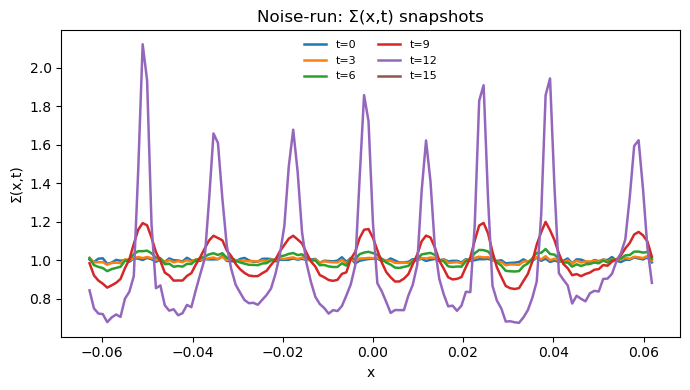

In [112]:
nsamp = 6
idxs = np.linspace(0, len(T)-1, nsamp, dtype=int)

plt.figure(figsize=(7,4))
for i in idxs:
    plt.plot(x, Sig[i], lw=1.8, label=f"t={T[i]:.3g}")

plt.xlabel("x")
plt.ylabel("Σ(x,t)")
plt.title("Noise-run: Σ(x,t) snapshots")
plt.legend(ncol=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

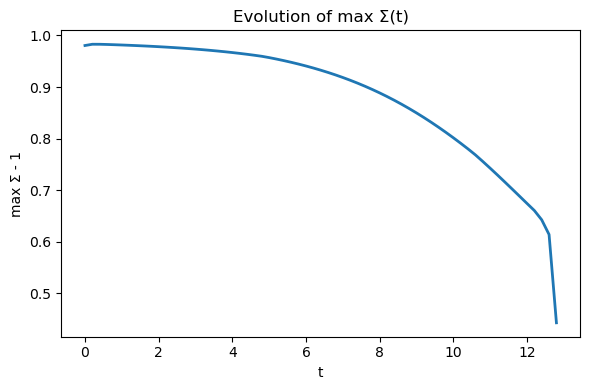

In [106]:
Sig_max = Sig.min(axis=1)   # maximum of Σ(x) for each time snapshot

plt.figure(figsize=(6,4))
plt.plot(T, Sig_max, lw=2)
plt.xlabel("t")
plt.ylabel("max Σ - 1")
plt.title("Evolution of max Σ(t)")
plt.tight_layout()

plt.show()